# Case Study: Tips Data

O-ring data was informative but with a small number of features and instances. This data set has 224 instances and seven features.

In [2]:
# Standard imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings


In [3]:
# Set up Notebook

%matplotlib inline
# We do this to ignore several specific warnings
warnings.filterwarnings("ignore")

# deactivate jedi for faster autocomplete
%config Completer.use_jedi = False

# plot styles
sns.set(style="white")

In [4]:
# Load tips data set
tdf = sns.load_dataset('tips')

# Display several random rows
tdf.sample(5)

,total_bill,tip,sex,smoker,day,time,size
94,22.75,3.25,Female,No,Fri,Dinner,2
51,10.29,2.60,Female,No,Sun,Dinner,2
177,14.48,2.00,Male,Yes,Sun,Dinner,2
71,17.07,3.00,Female,No,Sat,Dinner,3
198,13.00,2.00,Female,Yes,Thur,Lunch,2


To perform regression on the numeric features, we need both the numerical features and a target feature.

In this example, we will predict if a patron is a smoker or not based solely on the tree numerical features. 

First we start by by extracting the numerical features into a new df (for the independent variables):

In [5]:
# Extract dependent variable:
labels = (tdf.smoker == 'Yes').astype(float)
labels.value_counts()

0.0    151
1.0     93
Name: smoker, dtype: int64

In [6]:
# Extract numerical features as a df
numerical = ['total_bill', 'tip', 'size']
num_data = tdf[numerical]
num_data.sample(5)

,total_bill,tip,size
15,21.58,3.92,2
240,27.18,2.00,2
153,24.55,2.00,4
134,18.26,3.25,2
206,26.59,3.41,3


Given the independent and dependent variables, we are ready to construct our logistic regression model.

First we need to separate the data into training and testing sets. This requires reshaping our `labels` array to be properly sized for the sicket-learn library estimators: (N, 1) numpy array, where N is `len(array)`:

In [7]:
# import sklearn training-test split function:
from sklearn.model_selection import train_test_split

# set the ratio of blind testing:
frac = 0.25

# Reshapte the label array:
labels = labels.values.reshape(-1, 1)

In [8]:
# create test/train splits:
ind_train, ind_test, dep_train, dep_test = train_test_split(num_data,
                                                           labels,
                                                           stratify=labels,
                                                           test_size=frac,
                                                           random_state=23)

In [9]:
from sklearn.linear_model import LogisticRegression

# create and fit a new LR model
tips_model = LogisticRegression(C=1E6)
tips_model.fit(ind_train, dep_train)

# predict values
predicted = tips_model.predict(ind_test)

In [10]:
from sklearn.metrics import accuracy_score, classification_report

score = 100.0 * accuracy_score(dep_test, predicted)
print(f'Smoker [Numeric only] classification score = {score:4.2f}%')
print(classification_report(dep_test, predicted))

Smoker [Numeric only] classification score = 62.30%
              precision    recall  f1-score   support

         0.0       0.64      0.92      0.75        38
         1.0       0.50      0.13      0.21        23

    accuracy                           0.62        61
   macro avg       0.57      0.53      0.48        61
weighted avg       0.58      0.62      0.55        61



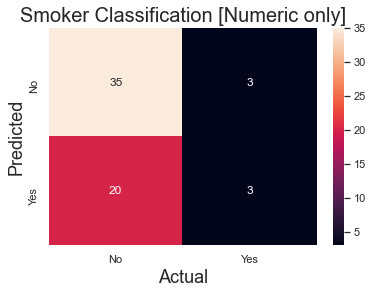

In [11]:
import mlplots as ml
ml.confusion(dep_test.reshape(dep_test.shape[0]), 
             predicted, ['No', 'Yes'], 2, 'Smoker Classification [Numeric only]')

In this simple example, our model provides a reasonable performance, except for the excess _false negatives_ where we over predict non-smokers to be smokers. While there are several techniques we could explore to improve the performance of this simple model, the easiest will be to include additional features in our model. This will require including categorical features in our model.

## LR: Categorical Features

Admittedly, our attempt to predict whether a patron is a smoker or not, based solely on the data in the _tips_ data set, is ambitious. Even if the model fails to perform sufficiently well, we may gain insight into our data and the relationship between the features.

As a result, we now transition to include categorical features in the model. To accomplish this we need to transform the single categorical feature into multiple features that correspond to the different values available to each categorical feature. In the linear regression notebook, this was performed by using the `LabelBinarizer` in the scikit-learn library.

Here we will use a different approach; the pandas library provides a `get_dummies` method that creates a new DataFrame from the categorical features in an existing DataFrame. A dummy feature is a binary feature that takes a value of `0` or `1` 

In [12]:
categorical = ['sex', 'day', 'time']

cat_data = pd.get_dummies(tdf[categorical])
cat_data.sample(5)

,sex_Male,sex_Female,day_Thur,day_Fri,day_Sat,day_Sun,time_Lunch,time_Dinner
159,1,0,0,0,0,1,0,1
237,1,0,0,0,1,0,0,1
37,0,1,0,0,1,0,0,1
232,1,0,0,0,1,0,0,1
205,0,1,1,0,0,0,1,0


In [13]:
tdf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244 entries, 0 to 243
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   total_bill  244 non-null    float64 
 1   tip         244 non-null    float64 
 2   sex         244 non-null    category
 3   smoker      244 non-null    category
 4   day         244 non-null    category
 5   time        244 non-null    category
 6   size        244 non-null    int64   
dtypes: category(4), float64(2), int64(1)
memory usage: 7.3 KB


In [14]:
# Join numerical and categorical features
# into new DataFrame
features = pd.concat([num_data, cat_data], axis=1)

# Create test/train splits for independent and dependent data
ind_train, ind_test, dep_train, dep_test \
    = train_test_split(features, labels, test_size=frac, random_state=23)

# Fit a new model to new data
tips_model.fit(ind_train, dep_train)

# Predict on test data
predicted = tips_model.predict(ind_test)

# Generate and display different evaluation metrics
score = 100.0 * accuracy_score(dep_test, predicted)
print(f'Smoker [Numeric & Categoric] classification score = {score:4.2f}%')
print(classification_report(dep_test, predicted))

Smoker [Numeric & Categoric] classification score = 72.13%
              precision    recall  f1-score   support

         0.0       0.75      0.90      0.82        42
         1.0       0.60      0.32      0.41        19

    accuracy                           0.72        61
   macro avg       0.67      0.61      0.62        61
weighted avg       0.70      0.72      0.69        61



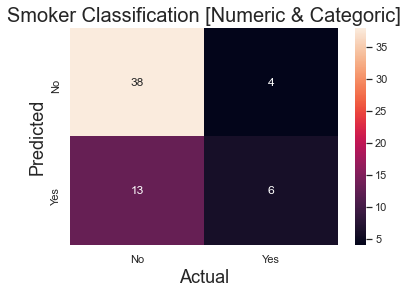

In [15]:
ml.confusion(dep_test.reshape(dep_test.shape[0]), 
             predicted, ['No', 'Yes'], 2, 'Smoker Classification [Numeric & Categoric]')

We can display the coefficients of our logistic regression model to understand which features contribute the most to future predictions. Simply put, the higher a coefficient, the more important that corresponding feature. In addition, a positive coefficient contributes towards a positive classification, while a negative coefficient contributes in the opposite manner, in this case non-smoker.

In [16]:
# Display coefficients for different features
for c, f in zip(tips_model.coef_[0], features.columns.values):
    print(f'{c:5.2f} * {f}')

 0.07 * total_bill
-0.09 * tip
-0.59 * size
 0.29 * sex_Male
 0.51 * sex_Female
-5.57 * day_Thur
 2.99 * day_Fri
 2.05 * day_Sat
 1.33 * day_Sun
 3.92 * time_Lunch
-3.12 * time_Dinner


Quite interesting results. Recall that we are trying to predict if a patron is a smoker or not, thus a positive classification would indicate the patron is predicted to be a smoker.  
1. First, our model indicates that more patrons at lunch are smokers as opposed to dinner.
2. Second, more smokers are predicted on Friday, while more non-smokers are predicted on Thursday
3. as the size of the group increases, the model predicts fewer smokers.

Whether these model insights make sense or not is a matter for debate; however, this does demonstrate one of the important results of logistic regression, we end up with a parametric model that we can explore for insights.

---

## Formula-Based Method

### Using `statsmodels`

Machine learning estimators in the scikit-learn library operate on Numpy arrays. However, we can construct a pandas DF from our data, and use the formula interface to the statsmodels module regression estimator to construct a logistic regression model.

In [17]:
# Generate new feature in our DF for the label
tdf['label'] = (tdf['smoker'] == 'Yes').astype(float)
tdf.sample(5)

,total_bill,tip,sex,smoker,day,time,size,label
118,12.43,1.8,Female,No,Thur,Lunch,2,0.0
161,12.66,2.5,Male,No,Sun,Dinner,2,0.0
212,48.33,9.0,Male,No,Sat,Dinner,4,0.0
140,17.47,3.5,Female,No,Thur,Lunch,2,0.0
46,22.23,5.0,Male,No,Sun,Dinner,2,0.0


In [18]:
import statsmodels.api as sm
from statsmodels.formula.api import logit

# Implement simple regression: Result ~ Input
sts_model = logit('label ~ total_bill + tip + size', data=tdf).fit()

# Display summary of model and fit parameters
sts_model.summary()

Optimization terminated successfully.
         Current function value: 0.632211
         Iterations 5


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                  label   No. Observations:                  244
Model:                          Logit   Df Residuals:                      240
Method:                           MLE   Df Model:                            3
Date:                Sun, 30 May 2021   Pseudo R-squ.:                 0.04877
Time:                        02:30:47   Log-Likelihood:                -154.26
converged:                       True   LL-Null:                       -162.17
Covariance Type:            nonrobust   LLR p-value:                  0.001236
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0903      0.434      0.208      0.835      -0.759       0.940
total_bill     0.0712      0.024      2.982      0.003       0.024       0.118
tip           -0.0846      0.137     -0.616      0.538      -0.354       0.184
size          -0.6866      0.206     -3.335      0.001      -1.090      -0.283
==============================================================================
"""

The displayed fit coefficient results agree, to a degree, with our earlier results. The total_bill and tips features show a small impact on our predicted result, while the size is negatively correlated with a positive prediction

In [19]:
# Display confusion matrix
sts_model.pred_table()

array([[140.,  11.],
       [ 72.,  21.]])

### Using `scikit-learn`

We can also employ a formula-based approach with the scikit-learn library by using the `patsy` module to construct NumPy matrices from a formula. 

Since we have already constructed our DF with both numeric, categorical, and label features, we can simply supply a formula to the `patsy` library to generate the desired NumPy matrices.

To indicate to the `patsy` module that a feature is categroical, we use: `C(feature)`. Then `dmatrices` function takes this formula and the supplied data and returns two dataframes: `x` for the independent variables and `y` for the dependent variable.  We need also to reshape the `y`, or label DataFrame, to work with the scikit-learn library estimators.

In [20]:
import patsy as pts

y, x = pts.dmatrices('label ~ total_bill+tip+size+C(sex)+C(day)+C(time)',
                     data=tdf, return_type='dataframe')

# y needs to be a 1D array for scikit learn
y = np.ravel(y)
x.sample(5)

,Intercept,C(sex)[T.Female],C(day)[T.Fri],C(day)[T.Sat],C(day)[T.Sun],C(time)[T.Dinner],total_bill,tip,size
87,1.0,0.0,0.0,0.0,0.0,0.0,18.28,4.00,2.0
233,1.0,0.0,0.0,1.0,0.0,1.0,10.77,1.47,2.0
74,1.0,1.0,0.0,1.0,0.0,1.0,14.73,2.20,2.0
127,1.0,1.0,0.0,0.0,0.0,0.0,14.52,2.00,2.0
52,1.0,1.0,0.0,0.0,1.0,1.0,34.81,5.20,4.0


Two important points to notice with `x`:
1. `patsy` automatically created the dummy, or binarized, features for our categorical features
2. patsy also dropped one option for each categorical feature. 

The second point is done to generate more robust results (something we probably should have been doing earlier). If we regress across all possible categorical options, we have introduced unnecessary correlations between our features. That is because if we have $n$ categorical features, we only need $n - 1$ dummy features to fully map all options.  
☞ This is known as multicollinearity, and can lead to problems with convergence. To avoid this, you should always drop one dummy feature!

We have, for example, explicitly excluded using `day=Thur` as a predictor. Thus, _Thursday_ is our reference category, for the `day` categorical features. Likewise, _Male_ is the reference category for the `sex` feature, and _Lunch_ is the reference category for the `time` feature. Later, when we quantify the impact of one feature on the prediction, the measurements will be with respect to this reference category.

---
Given these two DataFrames, we can construct an estimator, fit the training data, and predict on our test data

In [21]:
# Predict on test data
predicted = tips_model.predict(ind_test)

# Generate and display different evaluation metrics
score = 100.0 * accuracy_score(dep_test, predicted)
print(f'Smoker [Numeric & Categoric] classification score = {score:4.2f}%')
print(classification_report(dep_test, predicted))

Smoker [Numeric & Categoric] classification score = 72.13%
              precision    recall  f1-score   support

         0.0       0.75      0.90      0.82        42
         1.0       0.60      0.32      0.41        19

    accuracy                           0.72        61
   macro avg       0.67      0.61      0.62        61
weighted avg       0.70      0.72      0.69        61



Here are again the definitions of the above scores:

| | | |
| -- | -- | -- |
| Precision |  Positive Predictive Value | $\frac{TP}{TP + FP}$ |
| Accuracy |   | $\frac{TP + TN}{TP  + TN + FP + FN}$ |
| Recall (Sensitivity) |  True Positive Rate | $\frac{TP}{TP + FN}$ |
| F1-score ($F_1$)|  Harmonic mean of Precision and Recall | $\frac{2TP}{2TP + FN + FP}$ |
| Specificity |  True Negative Rate | $\frac{TN}{TN + FP}$ |
| False Positive Rate (Fall Out)|  FPR | $\frac{FP}{FP + TN}$ |
| False Discovery Rate |  FDR | $\frac{FP}{FP + TP}$ |



where

|  | |
| --- |--- |
| True  Negative (**TN**)| False Positive (**FP**)|
| False Negative (**FN**)| True Positive (**TP**)|

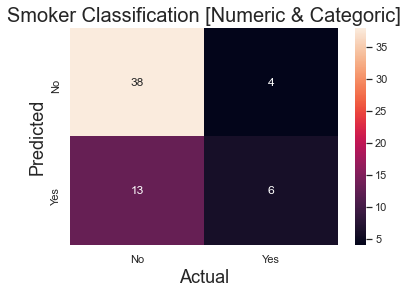

In [23]:
# Display confusion matrix
ml.confusion(dep_test.reshape(dep_test.shape[0]), 
             predicted, ['No', 'Yes'], 2, 'Smoker Classification [Numeric & Categoric]')

The confusion matrix indicates that the biggest problem our model faces is the prediction of false negatives.

## Marginal Effects

One challenge when building a logistic model with multiple independent features is understanding the _true_ effect of any one independent feature. To estimate these effects, one can compute the _marginal effects_, which quantifies the impact one feature has on the prediction while the other features are held constant.

Formally this is done by taking the partial derivative of the model with respect to the feature of interest, but we can compute them directly by using the `get_margeff` function from the statsmodels library. The following code cell demonstrates this by calling this method on the logistic regression model `sts_model` that we previously constructed by using the statsmodels library.

In [24]:
# Move this to text as an aside
mfx = sts_model.get_margeff()
print(mfx.summary())

        Logit Marginal Effects       
Dep. Variable:                  label
Method:                          dydx
At:                           overall
                dy/dx    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
total_bill     0.0157      0.005      3.203      0.001       0.006       0.025
tip           -0.0187      0.030     -0.618      0.537      -0.078       0.041
size          -0.1518      0.042     -3.638      0.000      -0.234      -0.070


The results displayed agree with what we saw earlier in the fit coefficients, namely that the `total_bill` and `tips` features do not strongly relate to a prediction. For example, a unit change in the `total_bill` feature will induce a change of 0.0157 in the prediction. Of these three features, the `size` has the largest impact at -0.1518, which once again indicates that a smaller `size` feature suggests a higher chance of a smoker, since that marginal effect is negative.

---
We could ask if we see this effect in descriptive statistics. The next two Code cells present the descriptive statistics for the original data split by the `smoker` feature.

In [25]:
# Smoker descriptive statistics
tdf[tdf['smoker'] == 'Yes'].describe()

,total_bill,tip,size,label
count,93.000000,93.000000,93.000000,93.0
mean,20.756344,3.008710,2.408602,1.0
std,9.832154,1.401468,0.810751,0.0
min,3.070000,1.000000,1.000000,1.0
25%,13.420000,2.000000,2.000000,1.0
50%,17.920000,3.000000,2.000000,1.0
75%,26.860000,3.680000,3.000000,1.0
max,50.810000,10.000000,5.000000,1.0


From this, we see that smokers do tend to be in smaller groups and give slightly smaller tips. However, to fully quantify this interpretation would require employing hypothesis testing.

---
## Odds Ratio

While marginal effect works well for numeric features, we can't take the derivative of a categorical, or discrete feature. Thus, we can also compute the _odds ratio_ to determine the association between the presence or absence of two features.

To compute an odds ratio, we hold one categorical value fixed, which is the reference group. This reference category was determined earlier when we held one categorical option out of the fit. Thus, when we calculate an odds ratio for the female instances, it is done with respect to the `sex=male` reference group.

We can use the odds ratio to determine the association, for example, between the `day` feature and the `time` feature, in order to determine if there is a relationship between these two features and the likelihood a patron is a smoker. The value of the odds ratio indicates how much more likely a patron is to be a smoker. We can also compute confidence intervals around these values to quantify the degrees of uncertainty associated with this ratio.

We first perform a logistic regression using all three numeric and categorical features on the full data set, and display a summary of the results:

In [26]:
# Implement simple regression: Result ~ Input
sts_c_model = logit('label ~ total_bill + tip + size + C(sex) + C(day) + C(time)', 
                    data=tdf).fit()

# Display model fit results
sts_c_model.summary()

Optimization terminated successfully.
         Current function value: 0.584335
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                  label   No. Observations:                  244
Model:                          Logit   Df Residuals:                      235
Method:                           MLE   Df Model:                            8
Date:                Sun, 30 May 2021   Pseudo R-squ.:                  0.1208
Time:                        11:25:53   Log-Likelihood:                -142.58
converged:                       True   LL-Null:                       -162.17
Covariance Type:            nonrobust   LLR p-value:                 4.550e-06
=====================================================================================
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept            -0.5777      0.538     -1.074      0.283      -1.632       0.477
C(sex)[T.Female]     -0.0242      0.311     -0.078      0.938      -0.634       0.586
C(day)[T.Fri]         3.0240      1.107      2.731      0.006       0.853       5.195
C(day)[T.Sat]         2.0200      1.261      1.602      0.109      -0.451       4.492
C(day)[T.Sun]         1.0578      1.274      0.830      0.406      -1.439       3.554
C(time)[T.Dinner]    -1.2317      1.219     -1.010      0.312      -3.621       1.158
total_bill            0.0723      0.025      2.898      0.004       0.023       0.121
tip                  -0.0903      0.144     -0.627      0.531      -0.373       0.192
size                 -0.5874      0.214     -2.750      0.006      -1.006      -0.169
=====================================================================================
"""

Next, we compute the odds ratio and confidence intervals for the different features, which is done for our logistic model by using the exponential function

In [27]:
# Odds ratios and 95% CI
ci = sts_c_model.conf_int()
ci['OR'] = sts_c_model.params
ci.columns = ['2.5%', '97.5%', 'OR']
print(np.exp(ci))

                       2.5%       97.5%         OR
Intercept          0.195529    1.610648   0.561185
C(sex)[T.Female]   0.530437    1.796312   0.976131
C(day)[T.Fri]      2.347570  180.306787  20.573836
C(day)[T.Sat]      0.636695   89.259933   7.538655
C(day)[T.Sun]      0.237217   34.969570   2.880171
C(time)[T.Dinner]  0.026750    3.183206   0.291804
total_bill         1.023657    1.128765   1.074927
tip                0.688984    1.211680   0.913689
size               0.365666    0.844746   0.555783


The results above indicate that `day=Fri` and `day=Sat` are important, which is also borne out by the fit coefficients.